Legacy Code

完成数据的加载，预处理和归一化

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
import random
from collections import Counter as count
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, f1_score, auc, roc_curve, roc_auc_score

train = pd.read_csv('data\\ads_train.csv')
test = pd.read_csv('data\\ads_test.csv')
pd.set_option('mode.chained_assignment', None)
test['y_buy']=0
# 删除id字段，对类别字段转换为onehot编码
train,test = train.drop('uniq_urls',axis=1),test.drop('uniq_urls',axis=1)
train,test = train.drop('Unnamed: 0',axis=1),test.drop('Unnamed: 0',axis=1)
train,test = train.fillna(0),test.fillna(0)

categorical_features = ['isbuyer','multiple_buy','multiple_visit']
train_cat,test_cat = pd.get_dummies(train[categorical_features]),pd.get_dummies(test[categorical_features])
train,test = train.drop(categorical_features, axis=1),test.drop(categorical_features, axis=1)
train,test = pd.concat([train, train_cat], axis=1),pd.concat([test, test_cat], axis=1)

# 分离训练、测试集
train_X,test_X = train.drop('y_buy', axis=1),test.drop('y_buy', axis=1)
train_Y,test_Y = train['y_buy'],test['y_buy']

X_resample, Y_resample = RandomOverSampler(random_state=0).fit_resample(train_X, train_Y)

Y_resample.describe()

from sklearn.model_selection import train_test_split
 
X_train, X_val, Y_train, Y_val = train_test_split(X_resample,Y_resample, test_size=0.2)

# 中位数填充
from sklearn.impute import SimpleImputer
median_imputer=SimpleImputer(strategy='median')
median_imputer.fit(X_train)
median_imputer.fit(X_val)
median_imputer.fit(test_X)

# 按照范围进行比例归一化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scale_features = ['buy_freq','visit_freq','buy_interval','sv_interval','expected_time_buy','expected_time_visit','last_buy','last_visit','num_checkins']
X_train[scale_features] = scaler.fit_transform(X_train[scale_features])
X_val[scale_features] = scaler.fit_transform(X_val[scale_features])
test_X[scale_features] = scaler.fit_transform(test_X[scale_features])

X_train.head()



,buy_freq,visit_freq,buy_interval,sv_interval,expected_time_buy,expected_time_visit,last_buy,last_visit,num_checkins,isbuyer,multiple_buy,multiple_visit
45983,-0.325828,-0.446564,-0.197121,-0.461628,0.145895,0.263982,0.487976,0.487976,0.116126,0,0,0
44228,-0.325828,0.526875,-0.197121,-0.410527,0.145895,0.286835,-0.833679,-0.833679,-0.501188,0,0,1
56975,-0.325828,-0.446564,-0.197121,-0.461628,0.145895,0.263982,0.803595,0.803595,-0.527867,0,0,0
62098,0.571762,-0.446564,-0.197121,-0.461628,0.145895,0.263982,0.034273,0.034273,-0.471748,1,0,0
4348,-0.325828,-0.446564,-0.197121,-0.461628,0.145895,0.263982,-0.419429,-0.419429,-0.282230,0,0,0


# 分离A，B组织的数据

A主体拥有以下数据：

    buy_freq：购买频率
    
    buy_interval：购买时间间隔
    
    last_buy：上次购买的时间
    
    isbuyer：是否有购买历史
    
    multiple_buy：是否购买了多次
    
    
B主体拥有以下数据：

    visit_freq：访问频率
    
    sv_interval：访问间隔
    
    expected_time_buy：平均每次从访问到购买的时间
    
    expected_time_visit：平均浏览的时间
    
    last_visit：上次访问的时间
    
    num_checkins：一共访问了多少次
    
    multiple_visit：是否多次访问
    
    y_buy:当前用户是否购买
    
注意： A主体没有y，因为A接收到的都是已经购买的记录，只浏览未购买的没被A捕获到

In [2]:
A_features = ['buy_freq','buy_interval','last_buy','isbuyer','multiple_buy']
A_X_train = X_train[A_features]
A_X_val = X_val[A_features]

In [3]:
B_features = ['visit_freq','sv_interval','expected_time_buy','expected_time_visit','last_visit','num_checkins','multiple_visit']
B_X_train = X_train[B_features]
B_X_val = X_val[B_features]

# 考虑AB方联合训练，采用纵向联邦学习

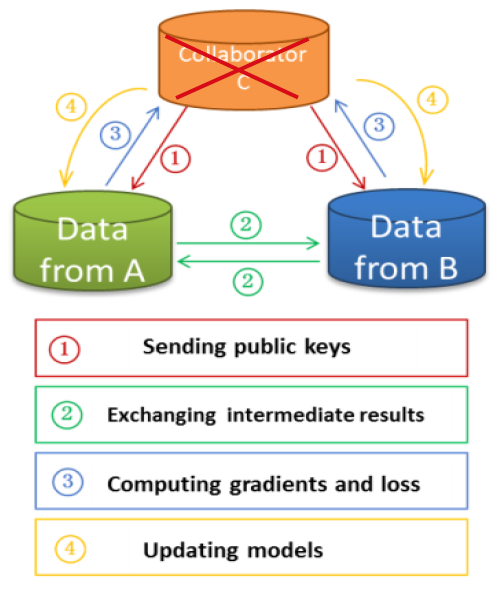

In [4]:
train_xa = A_X_train.T
val_xa = A_X_val.T
print(train_xa.shape,val_xa.shape)


(5, 60859) (5, 15215)


In [5]:
train_xb = B_X_train.T
val_xb = B_X_val.T
print(train_xb.shape,val_xb.shape)


(7, 60859) (7, 15215)


In [6]:
B_Y_train = np.array(Y_train.values).reshape((Y_train.shape[0],1)).T
B_Y_train.shape

B_Y_val = np.array(Y_val.values).reshape((Y_val.shape[0],1)).T
B_Y_val.shape

(1, 15215)

设定训练参数，初始化

设定超参数

In [7]:
# trainable params
W_A = np.random.randn(train_xa.shape[0],1)
W_B = np.random.randn(train_xb.shape[0],1)
print(W_A.shape,W_B.shape)

# hyperparameters
num_of_iter = 3000
learning_rate = 0.01


(5, 1) (7, 1)


第0步：

    - 中心协调者为A，B主体生成公私钥，发送公钥给AB

第一步：
    
    - A主体本地计算 ua = W_A dot Xa    ua是以样本数量为长度的数字矩阵
    - A主体本地计算 La = ua内积        La是一个数
    - ua 和 La 加密，发往B主体。 采用支持加法的同态加密。
    
第二步：

    - B主体收到 homo_ua, homo_La
    - B主体计算 ub = W_B dot Xb - Yb    ub是以样本数量为长度的数字矩阵
    - B主体计算 Lb = ub内积              Lb是一个数
    - B主体计算 homo_Lb
    - B 主体计算 homo_Lab = 2*homo_ua*(ub-yb)。  其中homo_ua是加密内容，(ub-yb)在B主体控制范围内是明文，数字矩阵。加法同态支持数乘，因此homo_Lab也是同态加密的状态。
    - B主体计算总 loss。 Loss = (ua+ub-yb)^2 = ua^2 + (ub-yb)^2 + 2*ua*(ub-yb)
                       homo_Loss           = homo_La + homo_Lb + homo_Lab
    - Homo_Loss 发给中心协调者，用于获取训练状态。
    
    - B主体计算homo_d = homo_ua + homo_ub
    
    - homo_d发给 A，自己也保留一份
    
第三步：

    - A 和 B 主体 计算加密后的梯度更新量，homo_grad = homo_d dot X
    
    - 此时可以把 homo_grad发给协调者C解密，发回梯度更新。
    
    - 但是考虑安全问题，A和 B都可以本地生成随机mask,使用homo_mask和homo_grad 相加发送给C
    
    - C 解密后发回 grad+mask， 两个主体减去mask，即为干净的梯度更新。
                                     

In [8]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

def Encrypt(x,name,showDetails=False):
    if showDetails:
        print("Encrypt {}".format(name))
    return x

def 
Decrypt(x,name,showDetails):
    if showDetails:
        print("!!!! Decrypt {}".format(name))
    return x

losses=[]

def ProcessRound(iteration,showDetails=False):
    global W_A,W_B,losses
    num_samples = train_xa.shape[1]
    # 前向，A 本地计算
    ua = np.dot(W_A.T,train_xa)
    La = np.dot(ua,ua.T)
    
    # 前向，A 加密
    homo_ua = Encrypt(ua,'ua',showDetails)
    homo_La = Encrypt(La,'La',showDetails)
    # 加法同态加密后的 ua ， La ，发给 B
    # B 本地运算
    ub = sigmoid(np.dot(W_B.T,train_xb))
    ub_diff_y = ub-B_Y_train
    Lb = np.dot(ub_diff_y,ub_diff_y.T)

    homo_ub_diff_y = Encrypt(ub_diff_y,'ub_diff_y',showDetails)

    homo_Lb = Encrypt(Lb,'Lb',showDetails)
    
    # B 使用同态特性计算
    homo_d = homo_ub_diff_y+homo_ua
    
    # 这里在B本地计算，ub_diff_y可以安全访问，形状为（1，m）数字矩阵。
    # 下面这行代码中的转置后点乘，可以通过element-wise数乘，然后按主方向累加的方式完成。
    homo_LAB = np.dot(homo_ua,ub_diff_y.T)
    homo_L = homo_La+homo_Lb+homo_LAB
    loss = np.sum(Decrypt(homo_L,'homo_L',showDetails)/num_samples)
    losses.append(loss)
    print("Iteration {} Loss:{}".format(iteration,loss), end='\r', flush=True) 
    # homo_d 发给A
    # homo_L 发给中心C (做统计使用)
    # A方本地同态计算
    
    homo_grad_a = homo_d*train_xa
    mask_a = np.random.randn(homo_grad_a.shape[0],homo_grad_a.shape[1])
    homo_mask_a = Encrypt(mask_a,'mask_a',showDetails)
    secret_grad_a = homo_grad_a+homo_mask_a
    
    # B方本地同态计算
    homo_grad_b = homo_d*train_xb
    mask_b = np.random.randn(homo_grad_b.shape[0],homo_grad_b.shape[1])
    homo_mask_b = Encrypt(mask_b,'mask_b',showDetails)
    secret_grad_b = homo_grad_b+homo_mask_b

    # homo_grad_a 和 homo_grad_b 发给C进行解密
    secret_grad_a_with_mask = Decrypt(secret_grad_a,'secret_grad_a_with_mask',showDetails)
    secret_grad_b_with_mask = Decrypt(secret_grad_b,'secret_grad_b_with_mask',showDetails)
    \
    clean_grad_a = secret_grad_a_with_mask - mask_a
    clean_grad_b = secret_grad_b_with_mask - mask_b
    
    avg_grad_a = np.average(clean_grad_a,axis=1)
    avg_grad_b = np.average(clean_grad_b,axis=1)

    W_A-=learning_rate*avg_grad_a.reshape(W_A.shape)
    W_B-=learning_rate*avg_grad_b.reshape(W_B.shape)
    
for i in range(10000):
    ProcessRound(i)

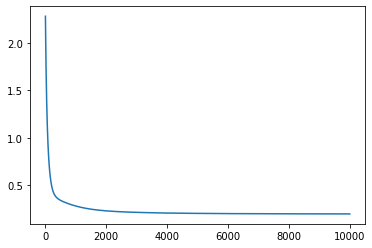

In [9]:
plt.plot(losses)

In [10]:
def Predict(XA,XB):
    global W_A,W_B
    return sigmoid(np.dot(W_A.T,XA)+np.dot(W_B.T,XB))
pred_probs = Predict(val_xa,val_xb)
pred_labels = np.where(pred_probs>0.5,1,0)
diff = Y_val.values-pred_labels[0]
acc = 1-np.sum(np.abs(diff))/len(diff)
acc

0.772198488333881